In [8]:
import numpy as np
import math
from random import random
import statistics as stats
import matplotlib.pyplot as plt

In [9]:
r = 0.02 # risk-free rate
mu = 0.05 # return of the market portfolio
a = 0.4 # factor of reversion to fundamentals (higher a, faster reversion)
volatilityY = 0.25 # volatility of the fundamentals
volatilityS = 0.2 # additional volatility of the stock

wage = 1 # per-year available funds (100% invested)
riskAversion = 3 # factor of agent risk aversion
startingAge = 25 # starting age of agents working and investing
retirementDuration = 20 # retirement duration in years

scenarios = 300
density = 10
T = 59
steps = T * density
deltaT = T / steps

JerryIsRight = False # whether Jerry's views hold
overRideJerry = True # whether the model goes by Jerry's assumptions
overRideJerryValue = 1

In [10]:
decrual = np.empty([retirementDuration * density - 1, scenarios])
JerryDecrual = np.empty([retirementDuration * density - 1, scenarios])

B0 = 1
Y0 = 1
S0 = a * Y0 / (a + mu)

variance = [0]*20
logVol = [0]*20



JerryStar = (mu - r) / (volatilityS ** 2 * riskAversion)

if overRideJerry:
    JerryStar = overRideJerryValue

In [125]:
def main(T = 59, density = 5, scenarios = 100, JerryIsRight = False, overRideJerry = True, overRideJerryValue = 1,
        volatilityS = 0.2, volatilityY = 0.1):

    steps = T * density
    deltaT = T / steps

    r = 0.02
    mu = 0.05
    a = 0.4
    wage = 1
    riskAversion = 3

    retirementDuration = 20
    startingAge = 25

    B0 = 1
    Y0 = 1
    S0 = a * Y0 / (a + mu)

    variance = [0]*20
    logVol = [0]*20
    
    decrual = np.empty([retirementDuration * density - 1, scenarios])
    JerryDecrual = np.empty([retirementDuration * density - 1, scenarios])

    stocks = [0] * steps
    economies = [0] * steps
    F = [0] * steps
    fStar = [0] * steps
    FJerry = [0] * steps

    for i in range(steps):
        FJerry[i] = [0] * scenarios
        F[i] = [0] * scenarios
        fStar[i] = [0] * scenarios
        stocks[i] = [0] * scenarios
        economies[i] = [0] * scenarios
        
    JerryStar = (mu - r) / (volatilityS ** 2 * riskAversion)

    if overRideJerry:
        JerryStar = overRideJerryValue

    dominantTerm = 2*S0**2*(a+mu+volatilityY**2)/(2*a+2*mu+volatilityY**2-volatilityS**2)

    for j in range(1, scenarios + 1):

        B = B0
        Y = Y0
        S = S0
        W1 = 0
        W2 = 0

        fStar[0][j - 1] = 0
        FJerry[0][j - 1] = 0
        F[0][j - 1] = 0

        SPosition = 0
        BPosition = 0
        JerrySPosition = 0
        JerryBPosition = 0

        for i in range(1, steps):
            fStar[i - 1][j - 1] = 0
            if i <= (T - retirementDuration) * steps / T:
                for l in range(1, retirementDuration + 1):
                    duration = T - retirementDuration + l - i / steps * T

                    exponentDominant = math.exp(duration*(2*mu+volatilityY**2))
                    correctionTerm = S0**2 - dominantTerm
                    exponent = math.exp(((duration/(a+mu+volatilityY**2))*(-2*a**2-a*volatilityS**2+mu*volatilityY**2-2*a*mu + a*volatilityS**2 + volatilityY**2*volatilityS**2 + mu * volatilityS ** 2)))

                    variance[l - 1] = dominantTerm*exponentDominant + correctionTerm*exponent - S0**2*math.exp(2*mu*duration)
                    logVol[l - 1] = (1 / duration * math.log(1 + variance[l - 1]/(S0 ** 2 * math.exp(2 * mu * duration)))) ** 0.5

                    fStar[i - 1][j - 1] = fStar[i - 1][j - 1] + (math.exp(mu)-1)*math.exp(mu*l)/(math.exp(mu)**20-1)*(mu - r)/(riskAversion*logVol[l - 1]**2)

                SPosition += deltaT * wage * fStar[i - 1][j - 1] / S
                BPosition += deltaT * wage * (1 - fStar[i - 1][j - 1]) / B

                JerrySPosition = JerrySPosition + deltaT*wage*JerryStar/S
                JerryBPosition = JerryBPosition + deltaT*wage*(1-JerryStar)/B
            else:
                #if (F[i - 1][j - 1] < 0) or (FJerry[i - 1][j - 1] < 0):
                    #print("bankrupt")
                cumulativeFStar = SPosition*S/F[i - 1][j - 1]
                excessReturn = min(mu*cumulativeFStar +r*(1-cumulativeFStar), 0.1)
                #print(excessReturn)
                #print(i)
                #print(j)
                #print(math.exp(excessReturn*(steps - i - 1)*deltaT))
                #print((math.exp(deltaT*excessReturn)-1))
                #print(math.exp(excessReturn*(steps-i)*deltaT)-1)
                periodWeight = math.exp(excessReturn*(steps - i - 1)*deltaT)*(math.exp(deltaT*excessReturn)-1)/(math.exp(excessReturn*(steps-i)*deltaT)-1)
                decrual[i - int((T-retirementDuration)*steps/T) - 1][j - 1] = F[i - 1][j - 1] * periodWeight
                SPosition = SPosition * (1 - periodWeight)
                BPosition = BPosition * (1 - periodWeight)

                excessReturnJerry = mu * JerryStar + r * (1 - JerryStar)
                periodWeightJerry = math.exp(excessReturnJerry*(steps-i - 1)*deltaT)*(math.exp(deltaT*excessReturnJerry)-1)/(math.exp(excessReturnJerry*(steps-i)*deltaT)-1)
                JerryDecrual[i - 1 - int((T - retirementDuration) * steps / T)][j - 1] = FJerry[i - 1][j - 1] * periodWeightJerry
                JerrySPosition = JerrySPosition * (1 - periodWeightJerry)
                JerryBPosition = JerryBPosition * (1 - periodWeightJerry)

            w = [deltaT ** 0.5 * np.random.normal(0, 1), deltaT ** 0.5 * np.random.normal(0, 1)]
            dB = r * B * deltaT
            B = B + dB

            if not JerryIsRight:
                dY = mu * Y * deltaT + volatilityY * Y * w[0]
                dS = a*(Y-S)*deltaT + volatilityS*S*w[1]
                Y = Y + dY
                S = S + dS

                F[i][j - 1] = SPosition*S + BPosition*B 
                FJerry[i][j - 1] = JerrySPosition * S + JerryBPosition * B

                stocks[i - 1][j - 1] = S
                economies[i - 1][j - 1] = Y
            else:
                dS = mu * S * deltaT + volatilityS * S * w[1]
                S = S + dS

                F[i][j - 1] = SPosition * S + BPosition * B
                FJerry[i][j - 1] = JerrySPosition * S + JerryBPosition * B

                stocks[i - 1][j - 1] = S
                economies[i - 1][j - 1] = None  

    
    Welfare = np.mean(-decrual ** (1 - riskAversion))
    WelfareJerry = np.mean(-(JerryDecrual) ** (1 - riskAversion))
        
    precision = 100
    for j in range (-200 * wage, 200 * wage + 1):
        i = j / 100
        dif = np.mean(-(JerryDecrual + i) ** (1-riskAversion)) - np.mean(-decrual ** (1-riskAversion))

        if  abs(dif) < precision:
            equityTransfer = i
            precision = abs(dif)
        else:
            equityTransfer = 0

    transfer = 100*equityTransfer/np.mean(decrual)

    output = {
        "F": np.array(F),
        "welfare": [Welfare, WelfareJerry],
        "transfer": transfer,
        "stocks": np.array(stocks),
        "econ": np.array(economies)
    }

    return(output)


In [12]:
def calc_fstar(r = 0.02, mu = 0.05, vY = 0.1, vS = 0.2, retDur = 20):
    r = r
    mu = mu
    volatilityY = vY
    volatilityS = vS
    retirementDuration = retDur
    B = B0
    Y = Y0
    S = S0
    W1 = 0
    W2 = 0
        
    F = [0] * steps
    fStar = [0] * ((T - 20) * density)
    FJerry = [0] * steps

    SPosition = 0
    BPosition = 0
    JerrySPosition = 0
    JerryBPosition = 0
    
    dominantTerm = 2*S0**2*(a+mu+volatilityY**2)/(2*a+2*mu+volatilityY**2-volatilityS**2)
    correctionTerm = S0**2 - dominantTerm


    for i in range(1, steps):
        if i <= (T - retirementDuration) * steps / T:
            for l in range(1, retirementDuration + 1):
                duration = T - retirementDuration + l - i / steps * T


                exponentDominant = math.exp(duration*(2*mu+volatilityY**2))

                exponent = math.exp(((duration/(a+mu+volatilityY**2))*(-2*a**2-a*volatilityS**2+mu*volatilityY**2-2*a*mu+ a*volatilityS**2+ volatilityY**2*volatilityS**2 +mu*volatilityS**2)))

                variance[l - 1] = dominantTerm*exponentDominant + correctionTerm*exponent - S0**2*math.exp(2*mu*duration)
                logVol[l - 1] = (1 / duration * math.log(1 + variance[l - 1]/(S0** 2 * math.exp(2 * mu * duration)))) ** 0.5


                fStar[i - 1] = fStar[i - 1] + (math.exp(mu)-1)*math.exp(mu*l)/(math.exp(mu)**20-1)*(mu - r)/(riskAversion*logVol[l - 1]**2)

            SPosition += deltaT * wage * fStar[i - 1] / S
            BPosition += deltaT * wage * (1 - fStar[i - 1]) / B

            JerrySPosition = JerrySPosition + deltaT*wage*JerryStar/S
            JerryBPosition = JerryBPosition + deltaT*wage*(1-JerryStar)/B
        else:
            cumulativeFStar = SPosition*S/F[i - 1]
            excessReturn = mu*cumulativeFStar +r*(1-cumulativeFStar)
            periodWeight = math.exp(excessReturn*(steps - i - 1)*deltaT)*(math.exp(deltaT*excessReturn)-1)/(math.exp(excessReturn*(steps-i)*deltaT)-1)
            decrual[i - int((T-retirementDuration)*steps/T) - 1] = F[i - 1] * periodWeight
            SPosition = SPosition * (1 - periodWeight)
            BPosition = BPosition * (1 - periodWeight)
           
            excessReturnJerry = mu * JerryStar + r * (1 - JerryStar)
            periodWeightJerry = math.exp(excessReturnJerry*(steps-i - 1)*deltaT)*(math.exp(deltaT*excessReturnJerry)-1)/(math.exp(excessReturnJerry*(steps-i)*deltaT)-1)
            JerryDecrual[i - 1 - int((T - retirementDuration) * steps / T)] = FJerry[i - 1] * periodWeightJerry
            JerrySPosition = JerrySPosition * (1 - periodWeightJerry)
            JerryBPosition = JerryBPosition * (1 - periodWeightJerry)

           
        w = [deltaT ** 0.5 * np.random.normal(0, 1), deltaT ** 0.5 * np.random.normal(0, 1)]
        dB = r * B * deltaT
        B = B + dB

        if not JerryIsRight:
            dY = mu * Y * deltaT + volatilityY * Y * w[0]
            dS = a*(Y-S)*deltaT + volatilityS*S*w[1]
            Y = Y + dY
            S = S + dS

            F[i] = SPosition*S + BPosition*B 
            FJerry[i - 1] = JerrySPosition * S + JerryBPosition * B
        else:
            dS = mu * S * deltaT + volatilityS * S * w[1]
            S = S + dS

            F[i] = SPosition * S + BPosition * B
            FJerry[i - 1] = JerrySPosition * S + JerryBPosition * B

    return(fStar)

In [20]:
calc_fstar(vY = 0.05)

[3.0461371755829525,
 3.044463137621654,
 3.0427842221038452,
 3.0411004075263977,
 3.039411672258677,
 3.0377179945415844,
 3.03601935248659,
 3.034315724074767,
 3.0326070871558057,
 3.0308934194470414,
 3.02917469853243,
 3.0274509018615703,
 3.025722006748667,
 3.0239879903715163,
 3.022248829770463,
 3.020504501847369,
 3.018754983364546,
 3.0170002509436986,
 3.0152402810648495,
 3.013475050065261,
 3.0117045341383304,
 3.0099287093325025,
 3.0081475515501426,
 3.00636103654642,
 3.0045691399281687,
 3.002771837152753,
 3.0009691035268937,
 2.9991609142055173,
 2.99734724419057,
 2.995528068329836,
 2.9937033613157262,
 2.991873097684086,
 2.9900372518129497,
 2.988195797921328,
 2.9863487100679476,
 2.984495962150004,
 2.982637527901882,
 2.98077338089388,
 2.9789034945309165,
 2.9770278420512217,
 2.9751463965250187,
 2.973259130853196,
 2.971366017765956,
 2.9694670298214683,
 2.9675621394044907,
 2.9656513187249964,
 2.9637345398167594,
 2.9618117745359607,
 2.95988299455976,

In [47]:
reg = calc_fstar()
fs_mu1 = calc_fstar(mu = 0.04)
fs_mu2 = calc_fstar(mu = 0.06)
fs_sigma1 = calc_fstar(vS = 0.3)
fs_sigma2 = calc_fstar(vY = 0.05)
time = [i for i in range(((T - 20) * density))]

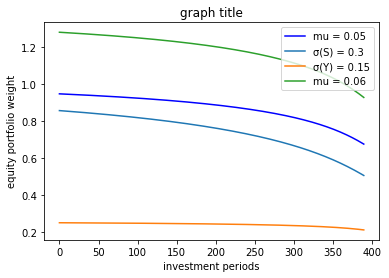

In [48]:
plt.plot(time, reg, label = 'mu = 0.05', color = 'blue')
plt.plot(time, calc_fstar(vS = 0.3), label = 'σ(S) = 0.3')
plt.plot(time, calc_fstar(vY = 0.2), label = 'σ(Y) = 0.15')
plt.plot(time, fs_mu2, label = 'mu = 0.06')
plt.title("Proportion of income invested into stocks over time")
plt.xlabel("Investment periods (5 per year)")
plt.ylabel("Equity portfolio weight")
plt.legend()

In [96]:
dp = 11

# jerry false override true
welfare_by_vY = [0] * dp
welfareJ_by_vY = [0] * dp
eqt_by_vY = [0] * dp

# jerry false override false
welfare2_by_vY = [0] * dp
welfareJ2_by_vY = [0] * dp
eqt2_by_vY = [0] * dp

#jerry true override false
welfare3_by_vY = [0] * dp
welfareJ3_by_vY = [0] * dp
eqt3_by_vY = [0] * dp

In [109]:

inc = 0.01

vY = [(0.05 + i * inc) for i in range(dp)]

for i in range(dp):
    print(i)
    wf = main(scenarios = 75, density = 5, volatilityY = vY[i], JerryIsRight = True, overRideJerry = False)
    welfare3_by_vY[i] = wf["welfare"][0]
    welfareJ3_by_vY[i] = wf["welfare"][1]
    eqt_by_vY[i] = wf["transfer"]
    
print("DONE")

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in power
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in power


1
2
3
4
5
6
7
8
9
10
DONE


In [65]:
len(welfare3_by_vY)

10

In [102]:
welfare_by_vY


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0, 0.5, 'welfare')

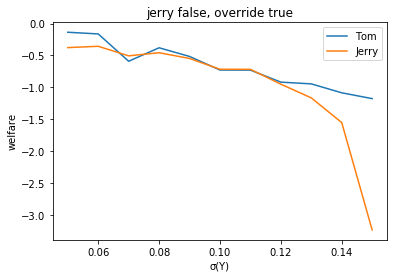

In [106]:
plt.plot(vY, welfare_by_vY, label = 'Tom')
plt.plot(vY, welfareJ_by_vY, label = 'Jerry')
plt.title("jerry false, override true")
plt.legend()
plt.xlabel("σ(Y)")
plt.ylabel("welfare")

Text(0, 0.5, 'welfare')

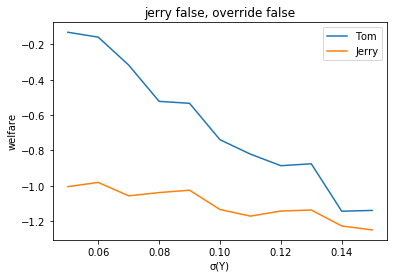

In [105]:
plt.plot(vY, welfare2_by_vY, label = 'Tom')
plt.plot(vY, welfareJ2_by_vY, label = 'Jerry')
plt.title("jerry false, override false")
plt.legend()
plt.xlabel("σ(Y)")
plt.ylabel("welfare")

Text(0, 0.5, 'welfare')

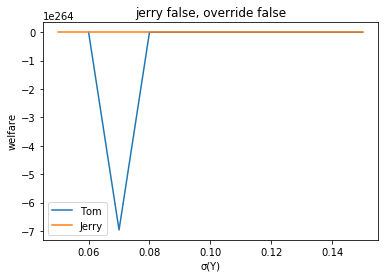

In [110]:
plt.plot(vY, welfare3_by_vY, label = 'Tom')
plt.plot(vY, welfareJ3_by_vY, label = 'Jerry')
plt.title("jerry false, override false")
plt.legend()
plt.xlabel("σ(Y)")
plt.ylabel("welfare")

In [112]:
def quantileplot(data, q):
    step = data.shape[0]
    scenario = data.shape[1]
    
    output = [0] * step
    
    for i in range(step):
        output[i] = np.quantile(data[i, :], q)
    
    return(output)

In [130]:
eff2 = main()["econ"]

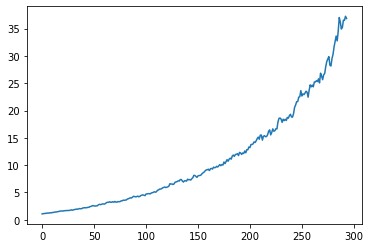

In [129]:
plt.plot(quantileplot(eff2[0: len(eff2) - 1], 0.9))

In [133]:
F123 = main()["F"]

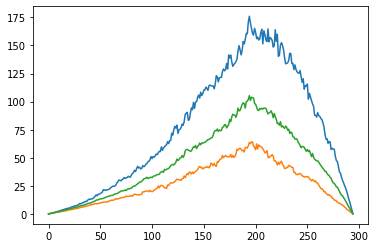

In [136]:
plt.plot(quantileplot(F123, 0.9))
plt.plot(quantileplot(F123, 0.1))
plt.plot(quantileplot(F123, 0.5))